## PLAsTiCC v2.0 alert simulation 

This is a demo of how we can add catalog simulations to LSST alerts in avro forma, which the Rubin project is using. 
This workbook includes the contributions of Rahul Biswas, Cameron Stockton, Martine Lokken, Alex Gagliano, Gautham Narayan, Renée Hlozek and the rest of the PLAsTiCC v2.0 team, and the DESC Alerts Topical Team.

Follow the README of this repository and then the README of `alert_packet` for setup. This involves installing `alert_packet` in some way.

This notebook is based on the examples and codes in `alert_packet` :https://github.com/lsst/alert_packet

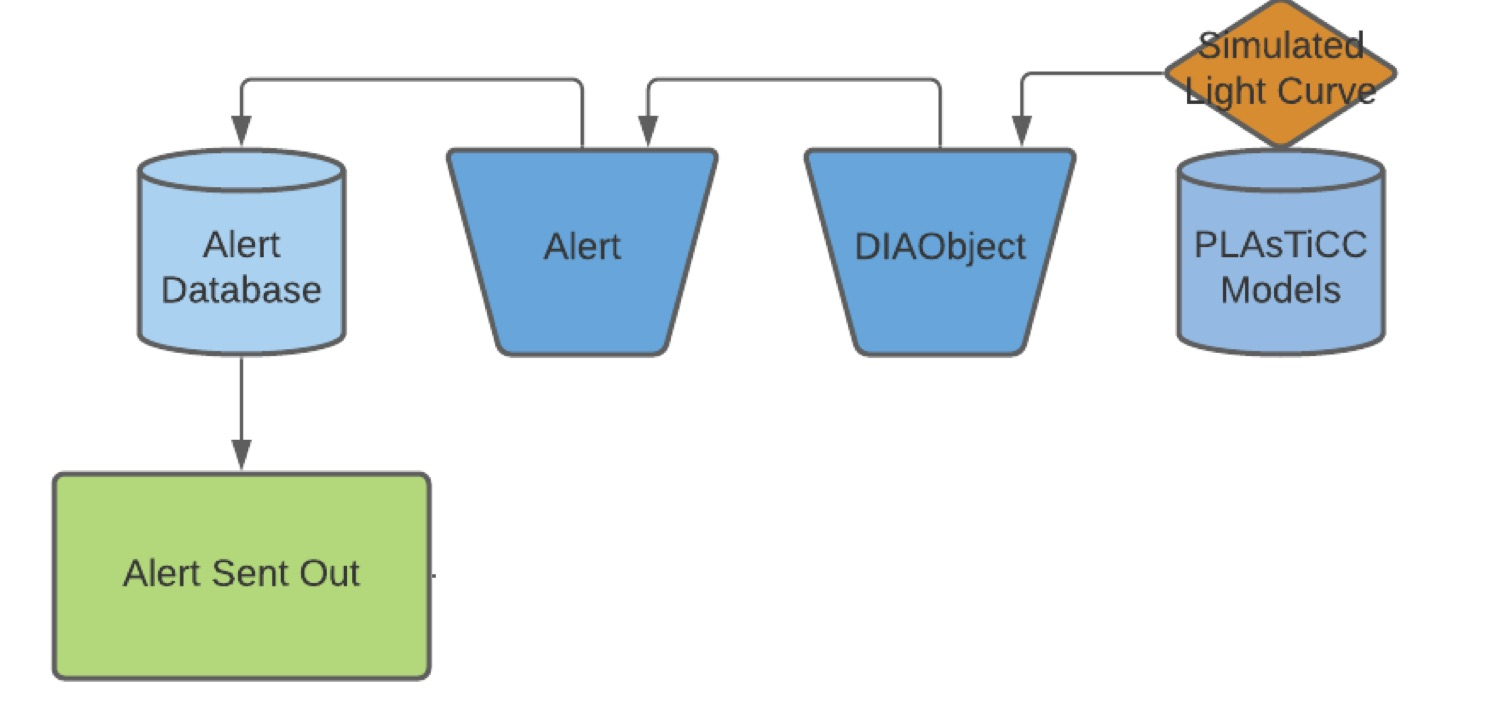

In [3]:
from IPython.display import Image
Image(filename='alert.jpg', width = 800) 

In [ ]:
import lsst.alert.packet

In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt
import os
from copy import copy
import json


In [ ]:
import json
import pandas as pd
from astropy.io import fits
import numpy as np
from astropy.time import Time
import glob
from avro.datafile import DataFileReader, DataFileWriter
from avro.io import DatumReader, DatumWriter

HOSTLIB_host=False

### These functions will enable us to plot the output from our avro object
Example functions taken from https://github.com/ZwickyTransientFacility/ztf-avro-alert/blob/master/notebooks/Working_with_avro_files.ipynb

In [ ]:
def make_dataframe(packet):
    df = pd.DataFrame(packet['diaSource'], index=[0])
    df_prv = pd.DataFrame(packet['prvDiaSources'])
    return pd.concat([df,df_prv], ignore_index=True)

def plot_lightcurve(dflc, days_ago=True):
    
    filter_color = {'g':'green', 'r':'red', 'u':'pink'}
    if days_ago:
        now = Time.now().jd
        t = dflc.midPointTai - now
        xlabel = 'Days Ago'
    else:
        t = dflc.midPointTai
        xlabel = 'Time (JD)'
    
    plt.figure()
    for fid, color in filter_color.items():
        # plot detections in this filter:
        w = (dflc.filterName == fid) & ~dflc.psFlux.isnull()
        if np.sum(w):
            plt.errorbar(t[w],dflc.loc[w,'apFlux'], dflc.loc[w,'apFluxErr'],fmt='.',color=color)
        #wnodet = (dflc.fid == fid) & dflc.magpsf.isnull()
        #if np.sum(wnodet):
         #   plt.scatter(t[wnodet],dflc.loc[wnodet,'diffmaglim'], marker='v',color=color,alpha=0.25)
    
    plt.gca().invert_yaxis()
    plt.xlabel(xlabel)
    plt.ylabel('Magnitude')

### Let's read in the schema from the Rubin alert.packet 
In this case we are modifying the usual alert schema to have (lots of) additional information in it. The expected list of host information will be more like host magnitudes and host errors, the light profile moments and PSF information. 

In [ ]:
# For those interested in modified alert schemas, this is included in the repo as an example, modified from the `alert_packet' repo
schema = lsst.alert.packet.Schema.from_file('./plasticc_schema/lsst.v4_1.alert.avsc','lsst.v4_1.alert')


We now read in an example json file that matches our schema.

In [ ]:
path = Path('./plasticc_schema/sample_data/')
with open(path/'plasticc.json') as f:
    alert_data = json.load(f)
    
    


### What does the alert data schema look like?
It has one diaSource object for the current epoch

In [ ]:
alert_data['diaSource']


### What about previous diaSources?
The previous diaSources for this diaObject are also nested in the schema

In [ ]:
alert_data['prvDiaSources']


This alert schema is just a dictionary: next we will read data from SNANA and write it to the values of the correct keys. We start by pulling off the first record to overwrite with SNANA information

In [ ]:
diasrc = alert_data['prvDiaSources'][0]

## Taking an SNANA file and porting information to alert
We will pull off models from the PLAsTiCC v2.0 DDF simulation, and assign the info to the alert packet. Note that we are adding information that isn't in the defined in the original LSST schema for this round. The following code takes the photometry and header files from SNANA and pushes them to a diaSource object for an index/epoch

In [ ]:
def import_diasrc_from_fits(head, phot,my_diasrc,hostlib_flag=False,i=0):
    
        my_diasrc['filterName'] = phot[1].data['FLT'][i]     
        my_diasrc['apFlux'] = phot[1].data['FLUXCAL'][i]
        my_diasrc['apFluxErr'] = phot[1].data['FLUXCALERR'][i]
        my_diasrc['snr'] = phot[1].data['FLUXCAL'][i]/phot[1].data['FLUXCALERR'][i]
        my_diasrc['midPointTai'] = phot[1].data['MJD'][i]
    
        # General properties
        my_diasrc['ra'] = head[1].data['RA'][i]
        my_diasrc['decl'] = head[1].data['DEC'][i]
        my_diasrc['nobs'] = head[1].data['NOBS'][i]
        my_diasrc['mwebv'] = head[1].data['MWEBV'][i]
        my_diasrc['mwebv_err'] = head[1].data['MWEBV_ERR'][i]
        my_diasrc['z_final'] = head[1].data['REDSHIFT_FINAL'][i]
        my_diasrc['z_final_err'] = head[1].data['REDSHIFT_FINAL_ERR'][i]
        
        if hostlib_flag:
        
                # properties of the host galaxy
            #print('using HOSTLIB values')
            my_diasrc['hostgal_logmass'] = head[1].data['SIM_HOSTLIB(LOGMASS_OBS)'][0]
            my_diasrc['hostgal_sfr']= head[1].data['SIM_HOSTLIB(STAR_FORMATION_RATE)'][0]
            my_diasrc['ellipticity'] = head[1].data['SIM_HOSTLIB(TOTAL_ELLIPTICITY)'][0]
            my_diasrc['size'] = head[1].data['SIM_HOSTLIB(SIZE_TRUE)'][0]
            my_diasrc['hostgal_z'] = head[1].data['HOSTGAL_SPECZ'][0]
            my_diasrc['hostgal_mag_u']= head[1].data['HOSTGAL_MAG_u'][0] #check
            my_diasrc['hostgal_mag_g']= head[1].data['SIM_HOSTLIB(MAG_TRUE_g_SDSS_z0)'][0]
            my_diasrc['hostgal_mag_r']= head[1].data['SIM_HOSTLIB(MAG_TRUE_r_SDSS_z0)'][0]   
            my_diasrc['hostgal_mag_i']= head[1].data['SIM_HOSTLIB(MAG_TRUE_i_SDSS_z0)'][0]  
            my_diasrc['hostgal_mag_z']= head[1].data['SIM_HOSTLIB(MAG_TRUE_z_SDSS_z0)'][0]
            
        else:
            #print('using uncorrelated SNANA values')
            my_diasrc['hostgal_logmass']= head[1].data['HOSTGAL_LOGMASS'][0]
            my_diasrc['hostgal_z']=head[1].data['HOSTGAL_SPECZ'][0]
            my_diasrc['hostgal_z_err']=head[1].data['HOSTGAL_SPECZ_ERR'][0]
            my_diasrc['hostgal_ssfr']= head[1].data['HOSTGAL_sSFR'][0]
            my_diasrc['hostgal_ssfr_err']= head[1].data['HOSTGAL_sSFR_ERR'][0]
            my_diasrc['hostgal_mag_u']= head[1].data['HOSTGAL_MAG_u'][0]
            my_diasrc['hostgal_mag_g']= head[1].data['HOSTGAL_MAG_g'][0]
            my_diasrc['hostgal_mag_r']= head[1].data['HOSTGAL_MAG_r'][0]
            my_diasrc['hostgal_mag_i']= head[1].data['HOSTGAL_MAG_i'][0]
            my_diasrc['hostgal_mag_z']= head[1].data['HOSTGAL_MAG_z'][0]
            
        # Common to both
        my_diasrc['hostgal_ra'] = head[1].data['HOSTGAL_RA'][0]
        my_diasrc['hostgal_dec'] = head[1].data['HOSTGAL_DEC'][0]
        my_diasrc['hostgal_snsep']= head[1].data['HOSTGAL_SNSEP'][0]
        my_diasrc['hostgal_magerr_u']= head[1].data['HOSTGAL_MAGERR_u'][0]
        my_diasrc['hostgal_magerr_g']= head[1].data['HOSTGAL_MAGERR_g'][0]
        my_diasrc['hostgal_magerr_r']= head[1].data['HOSTGAL_MAGERR_r'][0]
        my_diasrc['hostgal_magerr_i']= head[1].data['HOSTGAL_MAGERR_i'][0]
        my_diasrc['hostgal_magerr_z']= head[1].data['HOSTGAL_MAGERR_z'][0]
        my_diasrc['hostgal_logmass_err']= head[1].data['HOSTGAL_LOGMASS_ERR'][0]

        return my_diasrc


Now we read in the data from a particular SNANA model. In this case we are using a small SNANA simulation that includes the host properties (from work by Martine Lokken and Alex Gagliano). The full PLAsTiCC suite will contain alerts for a range of different objects from a variety of models.

In [ ]:
path = Path('plasticc_schema/sample_data')
with open(path/'plasticc.json') as f:
    alert_data_orig = json.load(f)

savedir='/global/cscratch1/sd/rhlozek/alerts/plasticc_alerts/Examples'
os.chdir(savedir)
retval = os.getcwd()
#simdir='/global/cscratch1/sd/kessler/SNANA_LSST_SIM/GSN_LSST_DDF/'
simdir='../hostSims/'
os.chdir(simdir)
modelname = glob.glob('*MODEL*')
os.chdir(retval)
print(f"Running alerts for the model list: {modelname}")


In [ ]:
fig = plt.figure(figsize=(12,60))
number_of_subplots=len(modelname)
#print(number_of_subplots)

# Some objects will not have data, so as we iterate over objects we keep track of those that were successfully written to file
keep = -9*np.ones(len(modelname))


for countm,name in enumerate(modelname):
    print(name)
    # Open the photometry file and the header files
    name_head=simdir+'/'+name+'/'+'%s-0001_HEAD.FITS.gz'%name
    name_phot=simdir+'/'+name+'/'+'%s-0001_PHOT.FITS.gz'%name
    
    
#     name_head=simdir+name+'/'+'GSN_LSST_DDF_NONIaMODEL0-0001_HEAD.FITS.gz'
#     name_phot=simdir+name+'/'+'GSN_LSST_DDF_NONIaMODEL0-0001_PHOT.FITS.gz'
    
    
    head = fits.open(name_head)
    head_cols=head[1].columns
    phot = fits.open(name_phot)
    phot_cols=phot[1].columns

    # now take header information off the photometry just to plot the models
    mjd = phot[1].data['MJD']
    mag = phot[1].data['SIM_MAGOBS']
    

    
    try:
        # The SNANA objects are stored with -777 between objects in a given model. 
        # For this demo we pull off only the first object in the model
        bound = np.where(mjd==-777)[0][0]-1
        
        if number_of_subplots==1:
             ax1 = plt.subplots(1,1)
        else: 
            ax1 = plt.subplot(number_of_subplots,1,countm+1)

        plt.plot(mjd, mag,'.')
        plt.text(60600,45, '%s'%name)
        plt.axis([60500,64000, 20,50])

        # copy the original alert data and clear all old sources
        alert = copy(alert_data_orig)
        diasrc = alert_data_orig['prvDiaSources'][0]
        my_diasrc = copy(diasrc)
        alert = copy(alert_data_orig)
        alert['prvDiaSources'].clear()
        
        
        # Make a dummy source ID and import additional information to the diaSource
        my_diasrc['diaSourceId'] = np.int(28132306237521+1000*np.random.uniform())
        my_diasrc = import_diasrc_from_fits(head, phot,my_diasrc,HOSTLIB_host,i=0)        
        alert['diaSource'] = my_diasrc
        
        # Writing the g band light curves to a dummy alert for now
        ginds = np.where(phot[1].data['FLT'][0:bound]=='g')[0]
        
        # for each item in the light curve, create a new diaSource or 
        # append the list of previous diaSources
        for count, i in enumerate(ginds):
            #print(count,i)
            my_diasrc = copy(diasrc)
            my_diasrc['diaSourceId'] = my_diasrc['diaSourceId']+count+1
            my_diasrc = import_diasrc_from_fits(head, phot,my_diasrc,HOSTLIB_host,i)
            alert['prvDiaSources'].append(alert['diaSource'])
            alert['diaSource'] = my_diasrc

        # serialize the alert    
        avro_bytes = schema.serialize(alert)
        messg = schema.deserialize(avro_bytes)
        iterNum=0
        
        # keep a record of if we indeed have a viable light curve to save
        keep[countm]=int(countm)
        with open("plasticcAlert_%s_%i.avro"%(name,iterNum), "wb") as f:
            schema.store_alerts(f, [alert])
        print(f"Saving model {name} as plasticcAlert_{name}_{iterNum}.avro")
    except:
        print(f"This model {name} seems to have no data")
        keep[countm]=int(0)
    print(f"Done saving models")
    

In [ ]:
keep = np.where(keep!=-9)[0]



In [ ]:
#print(keep)
for count in keep:
    iterNum=0
    print(count, modelname[count])
    
    fname= savedir+'/'+"plasticcAlert_%s_%i.avro"%(modelname[count],iterNum)
    print(f"Reading {fname}")
    with open(fname,'rb') as f:
        freader = DataFileReader(f,DatumReader())
        for alert in freader:
            dflc = make_dataframe(alert)
            plot_lightcurve(dflc)
            
            